In [1]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio as rio
import pandas as pd
from rasterio.windows import Window, from_bounds,bounds
from rasterio.plot import reshape_as_raster,reshape_as_image

In [2]:
src = rio.open('http://s3.eu-central-1.wasabisys.com/eumap/lcv/lcv_rgb_landsat.glad.ard_p50_30m_0..0cm_20110625..20110912_eumap_epsg3035_v1.0.tif')

In [3]:
src.meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': 0.0,
 'width': 188000,
 'height': 151000,
 'count': 3,
 'crs': CRS.from_epsg(3035),
 'transform': Affine(30.0, 0.0, 900000.0,
        0.0, -30.0, 5460010.0)}

In [4]:
src.overviews(2)

[2, 4, 8, 16, 32, 64, 128, 256]

In [5]:
thumbnail = src.read(out_shape=(3, src.height // 256, src.width // 256))

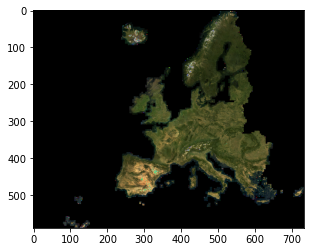

In [8]:
plt.imshow(np.moveaxis(thumbnail,0,-1)*5)

# Retrive the image for the defined boundry

In [9]:
windows = from_bounds(4640522.0322,3219820.7558,4660024.4587,3235260.5911, src.transform)

In [10]:
src.transform

Affine(30.0, 0.0, 900000.0,
       0.0, -30.0, 5460010.0)

In [11]:
windows

Window(col_off=124684.06774, row_off=74158.31363000002, width=650.0808833333431, height=514.661176666661)

In [12]:
img = src.read(window=windows)

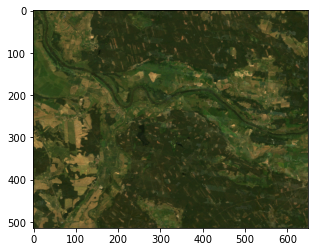

In [13]:
plt.imshow(reshape_as_image(img)*5)

# Retrive the image based on the blocks

In [14]:
src.block_shapes

[(1024, 1024), (1024, 1024), (1024, 1024)]

In [15]:
w = []
i = 0
for ji, window in src.block_windows():
    r = src.read( window=window)
    if r.max() > 1:
        w.append(window)
        i +=1
    if i>150:
        break
    del r

In [204]:
window_ = w[81]

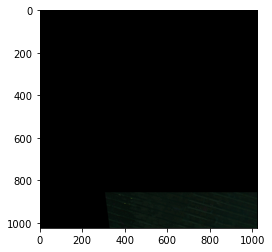

In [205]:
img_block = src.read(window=window_)
plt.imshow(reshape_as_image(img_block)*5)

In [206]:
minx, miny, maxx, maxy = bounds(window_, src.transform)
tr = rio.transform.from_bounds(minx, miny, maxx, maxy, window_.width, window_.height)
profile = rio.profiles.Profile()
profile.update(driver='GTiff', width=window_.width, height=window_.height, transform=tr,
                crs=rio.crs.CRS.from_epsg(3035),count=3,dtype=img.dtype)
with rio.open('./test_img.tif', 'w', **profile) as target:
    target.write(img_block)

# Convert block to CSV

In [207]:
def _get_index(array):
    return np.nonzero(array[1,...])

def _get_coord_X(index, offset, size):
    return index * size + offset + (size / 2)

def _get_coord_Y(index, offset, size):
    return index * (-1 * size) + offset - (size / 2)

Px_size = src.transform[0]
    

In [208]:
(y_index, x_index) = _get_index(img_block)
x_coords = _get_coord_X(x_index, minx, Px_size)
y_coords = _get_coord_Y(y_index, maxy, Px_size)
X = pd.Series(x_coords)
Y = pd.Series(y_coords)
CC_number = (
    np.floor(Y / Px_size) * 100000 + np.floor(X / Px_size)
).convert_dtypes()

df_coords = pd.DataFrame(
    {
        "X": X.astype("float32", copy=False),
        "Y": Y.astype("float32", copy=False),
        "CC_number": CC_number.astype("int", copy=False),
    }
)

In [209]:
df_values = pd.DataFrame(reshape_as_image(img_block).reshape(-1,3),columns=["R", "G", "B"])
df_values = df_values[(df_values.T != 0).any()].reset_index(drop = True)

In [210]:
df = pd.concat([df_coords,df_values],axis=1)

In [211]:
df.head()

,X,Y,CC_number,R,G,B
0,4626285.0,5249995.0,17500054209,1,4,3
1,4626315.0,5249995.0,17500054210,1,3,2
2,4626345.0,5249995.0,17500054211,4,3,3
3,4626375.0,5249995.0,17500054212,3,2,3
4,4626405.0,5249995.0,17500054213,1,3,3


In [212]:
import geopandas as gpd
from shapely.geometry import Point

In [213]:
df["coords"] = list(zip(df["X"], df["Y"]))
df["coords"] = df["coords"].apply(Point)
gdf = gpd.GeoDataFrame(df, geometry="coords")

In [214]:
gdf.to_file('points_ppp.geojson', driver='GeoJSON')

In [215]:
test_srx = rio.open('./COG/landsat_2000_CH.tif')

In [217]:
test_srx.overviews(2)

[2, 4, 8, 16]